In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, select

In [5]:
# Create engine using the "hawaii.sqlite" database file
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### 1. Design a query to retrieve the last 12 months of precipitation data and plot the results

Define function to convert strings to datetimes

In [13]:
# Define function to convert strings to datetimes
def convert(date_time): 
    format ="%Y-%m-%d" # The format 
    datetime_str = dt.datetime.strptime(date_time, format) 
   
    return datetime_str

Calculate date ranges needed for query

In [14]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Last date of data: {last_date[0]}")

# Set variable to hold date of 1 year prior
year_prior = convert(last_date[0]) - dt.timedelta(days=365)
print(f"One year before: {year_prior}")

Last date of data: 2017-08-23
One year before: 2016-08-23 00:00:00


Query data, convert to dataframe and cleanup

In [15]:
# Perform a query to retrieve the data and precipitation scores
date_data = (session.query(Measurement.date, Measurement.prcp)
            .filter(Measurement.date >= year_prior))

# Save the query results as a Pandas DataFrame and set the index to the date column
date_data_df = pd.read_sql_query(date_data.statement, session.get_bind())

# Convert "date" column to datetime type
date_data_df["date"] = pd.to_datetime(date_data_df["date"], yearfirst=True, infer_datetime_format=True)

#Set index
date_data_df = date_data_df.set_index("date", drop=False)

# Drop unavailable columns
date_data_df = date_data_df.dropna()

# Sort the dataframe by date
date_data_df = date_data_df.sort_index()

date_data_df = date_data_df.rename(columns=
                                  {"date":"Date",
                                  "prcp":"Precipitation"})
date_data_df.head()

,Date,Precipitation
date,,
2016-08-24,2016-08-24,0.08
2016-08-24,2016-08-24,1.22
2016-08-24,2016-08-24,2.28
2016-08-24,2016-08-24,1.45
2016-08-24,2016-08-24,2.15


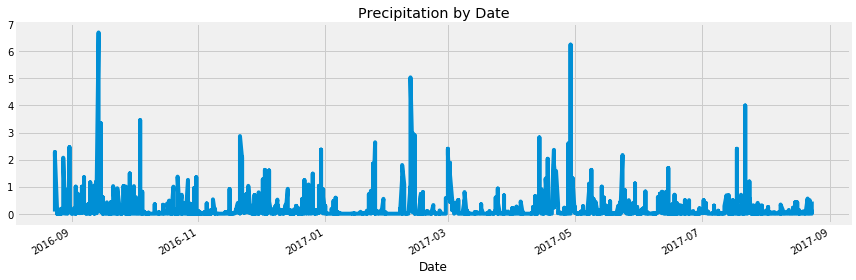

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data

# Set title
title = "Precipitation by Date"

# Create chart
precip_chart = date_data_df.plot("Date", "Precipitation", title=title, figsize=(12,4), legend=False)

# Set x and y labels
precip_chart.set_xlabel = "Date"
precip_chart.set_ylabel = "Precipitation (Inches)"

# Set layout
plt.tight_layout()

# Save chart to new variable and show plot.
precip_chart = plt.gcf()
plt.show()


In [17]:
# Save figure
precip_chart.savefig("../Images/Precipitation_vs_Date.png")

2. Use Pandas to calcualte the summary statistics for the precipitation data

In [18]:
# Apply .describe() function to dataframe
date_data_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


3. Design a query to show how many stations are available in this dataset?


In [19]:
# Set a query to count unique stations in the data range
station = (session.query(func.distinct(Measurement.station))
           .filter(Measurement.date >= year_prior)
           .count())
print(f"There are {station} stations in this data set.")

There are 7 stations in this data set.


4. What are the most active stations? (i.e. what stations have the most rows)?
 List the stations and the counts in descending order.


In [20]:
# Set a query to list unique stations and count occurrences
print("The following are the stations and their respective counts, in descending order of counts.")
for row in (session.query(Measurement.station, func.count(Measurement.station))
            .filter(Measurement.date >= year_prior)
            .group_by(Measurement.station)
            .order_by(func.count(Measurement.station).desc())
            .all()):
    print(row)

The following are the stations and their respective counts, in descending order of counts.
('USC00519397', 360)
('USC00519281', 351)
('USC00516128', 348)
('USC00513117', 342)
('USC00519523', 336)
('USC00514830', 304)
('USC00517948', 182)


5. Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station.


In [21]:
# Min temp query
min_temp = (session.query(func.min(Measurement.tobs))
          .filter(Measurement.date >= year_prior)
          .filter(Measurement.station == "USC00519397")
          .all())

# Max temp query
max_temp = (session.query(func.max(Measurement.tobs))
          .filter(Measurement.date >= year_prior)
          .filter(Measurement.station == "USC00519397")
          .all())

# Avg temp query
avg_temp = (session.query(func.avg(Measurement.tobs))
          .filter(Measurement.date >= year_prior)
          .filter(Measurement.station == "USC00519397")
          .all())

# Print report.
print(f"The lowest temp recorded at station USC00519397 was {min_temp[0][0]} degrees Fahrenheit.")
print(f"The highest temp recorded at station USC00519397 was {max_temp[0][0]} degrees Fahrenheit.")
print(f"The average temp recorded at station USC00519397 was {avg_temp[0][0]} degrees Fahrenheit.")

The lowest temp recorded at station USC00519397 was 60.0 degrees Fahrenheit.
The highest temp recorded at station USC00519397 was 87.0 degrees Fahrenheit.
The average temp recorded at station USC00519397 was 75.19444444444444 degrees Fahrenheit.


6. Choose the station with the highest number of temperature observations.
Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [22]:
# Write query
year_data = (session.query(Measurement.date, Measurement.tobs)
            .filter(Measurement.date >= year_prior)
            .filter(Measurement.station == "USC00519397"))

# Save the query results as a Pandas DataFrame and set the index to the date column
year_data_df = pd.read_sql_query(year_data.statement, session.get_bind())

# Convert "date" column to datetime type
year_data_df["date"] = pd.to_datetime(year_data_df["date"], yearfirst=True, infer_datetime_format=True)
year_data_df.head()

,date,tobs
0,2016-08-24,79.0
1,2016-08-25,80.0
2,2016-08-26,79.0
3,2016-08-27,77.0
4,2016-08-28,78.0


In [23]:
# Create bin_list to hold dates as strings
bin_list = ["2016-08-22", "2016-09-22", "2016-10-22", "2016-11-22", "2016-12-22", "2017-01-22", "2017-02-22",
            "2017-03-22", "2017-04-22", "2017-05-22", "2017-06-22", "2017-07-22", "2017-08-24"]

# Run datetime function on bin_list, and add to list of size_bins
size_bins = []
for x in bin_list:
    date = convert(x)
    size_bins.append(date)

In [24]:
# Create labels for bins
group_names = ["Sep 2016", "Oct 2016", "Nov 2016", "Dec 2016", "Jan 2017","Feb 2017",
              "Mar 2017", "Apr 2017", "May 2017", "Jun 2017", "Jul 2017", "Aug 2017"]

# Cut the bins
year_data_df["Month"] = pd.cut(year_data_df["date"], bins=12, labels=group_names)
year_data_df = year_data_df.sort_values(by="date")
year_data_df.head()

,date,tobs,Month
0,2016-08-24,79.0,Sep 2016
1,2016-08-25,80.0,Sep 2016
2,2016-08-26,79.0,Sep 2016
3,2016-08-27,77.0,Sep 2016
4,2016-08-28,78.0,Sep 2016


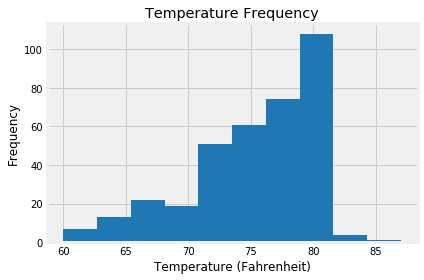

In [25]:
# Plot dates as histogram

# Set title
title = "Temperature Frequency"

# Create chart
temp_freq = year_data_df["tobs"].plot(kind="hist", title=title, color="tab:blue")

# Set labels
temp_freq.set_xlabel("Temperature (Fahrenheit)")
temp_freq.set_ylabel("Frequency")

# Set layout
plt.tight_layout()

# Show plot
temp_freq = plt.gcf()
plt.show()

In [26]:
# Save figure
temp_freq.savefig("../Images/Temperature_Frequency.png")

## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [33]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [34]:
# Plot the daily normals as an area plot with `stacked=False`
